### First Cut Model

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load Train Dataset
import pandas as pd

Final_Dataset_Provider_Train=pd.read_csv("/content/drive/MyDrive/bpm_fraud/new_data.csv")

Final_Dataset_Provider_test=pd.read_csv("/content/drive/MyDrive/bpm_fraud/test_data.csv")


In [6]:
Final_Dataset_Provider_Train.columns

Index(['Unnamed: 0', 'Provider', 'InscClaimAmtReimbursed',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'Hospitalization_Duration', 'Claim_Period', 'ExtraClaimDays',
       'Inpatient_or_Outpatient', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidar

In [7]:
provider_counts = Final_Dataset_Provider_Train['Provider'].value_counts()

# Display the counts
print(provider_counts)

PRV51459    8240
PRV53797    4739
PRV51574    4444
PRV53918    3588
PRV54895    3436
            ... 
PRV55792       1
PRV53084       1
PRV52746       1
PRV54449       1
PRV56377       1
Name: Provider, Length: 5410, dtype: int64


In [8]:
import pandas as pd
from sklearn.utils import shuffle

# Load the dataset
df = Final_Dataset_Provider_Train

# Calculate counts for each provider
provider_counts = df['Provider'].value_counts().reset_index()
provider_counts.columns = ['Provider', 'counts']

# Total dataset size
total_size = provider_counts['counts'].sum()

# Shuffle DataFrame
provider_counts = shuffle(provider_counts, random_state=42)

# Compute target sizes for train and test sets
train_target_size = 0.7 * total_size
current_train_size = 0

# Initialize train and test DataFrames
train_providers = []
test_providers = []

# Allocate providers to train and test sets ensuring no overlap
for index, row in provider_counts.iterrows():
    if current_train_size + row['counts'] <= train_target_size:
        train_providers.append(row['Provider'])
        current_train_size += row['counts']
    else:
        test_providers.append(row['Provider'])

# Create train and test DataFrames based on provider lists
train_df = df[df['Provider'].isin(train_providers)]
test_df = df[df['Provider'].isin(test_providers)]

print(f"Train set shape: {train_df.shape} entries")
print(f"Test set shape: {test_df.shape} entries")


Train set shape: (390747, 50) entries
Test set shape: (167464, 50) entries


### Now I can use this data to train model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [17]:
# # Seperate dependent and independent variables
# x= Final_Dataset_Provider_Train.drop(axis=1,columns=['PotentialFraud','Provider','Unnamed: 0'])
# y = Final_Dataset_Provider_Train['PotentialFraud']

In [10]:
x_train= train_df.drop(axis=1,columns=['PotentialFraud','Provider'])
y_train = train_df['PotentialFraud']

x_val= test_df.drop(axis=1,columns=['PotentialFraud','Provider'])
y_val = test_df['PotentialFraud']

In [11]:
# # Standardize the data (train and test)
# standard_scaler = StandardScaler()
# standard_scaler.fit(x)
# x_std = standard_scaler.transform(x)
# #x_test_std = standard_scaler.transform(x_test)

from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
standard_scaler = StandardScaler()

# Fit and transform x
x_std_train = standard_scaler.fit_transform(x_train)
x_std_val = standard_scaler.fit_transform(x_val)
# x_std now contains the standardized features

In [20]:
# # # Standardize the data (train and test)
# # standard_scaler = StandardScaler()
# # standard_scaler.fit(x)
# # x_std = standard_scaler.transform(x)
# # #x_test_std = standard_scaler.transform(x_test)

# from sklearn.preprocessing import StandardScaler

# # Initialize StandardScaler
# standard_scaler = StandardScaler()

# # Fit and transform x
# x_std = standard_scaler.fit_transform(x)

# x_std now contains the standardized features


In [21]:
#x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.3,random_state=101,stratify=y,shuffle=True)

In [12]:
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(True)
    plt.show()

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()

    return train_prediction, test_prediction


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)

    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))

    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    test_recall_score = recall_score(y_test, test_prediction)
    test_accuracy_score=accuracy_score(y_test, test_prediction)

    return test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score

#### Now train with best parameters using LogisticRegression

In [38]:
# # # https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# logreg_cv.fit(x_std_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [39]:
# print("best parameters = ",logreg_cv.best_params_)
# print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.01, 'penalty': 'l2'}
roc_auc_score : 0.9361371784203725


In [40]:
log_reg = LogisticRegression(C=0.01, penalty='l2')
log_reg.fit(x_std_train, y_train)

# from sklearn.linear_model import LogisticRegressionCV

# log_reg = LogisticRegressionCV(cv=10,class_weight='balanced',random_state=123)
# log_reg.fit(x_std_train, y_train)

LogisticRegression(C=0.01)

Train AUC =  0.7636822294965946
Test AUC =  0.7992206948822224


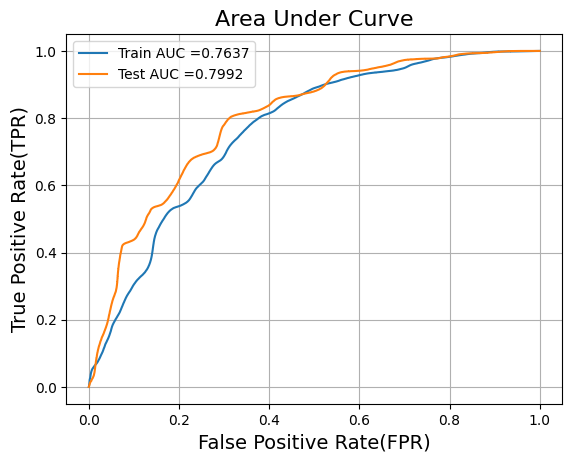

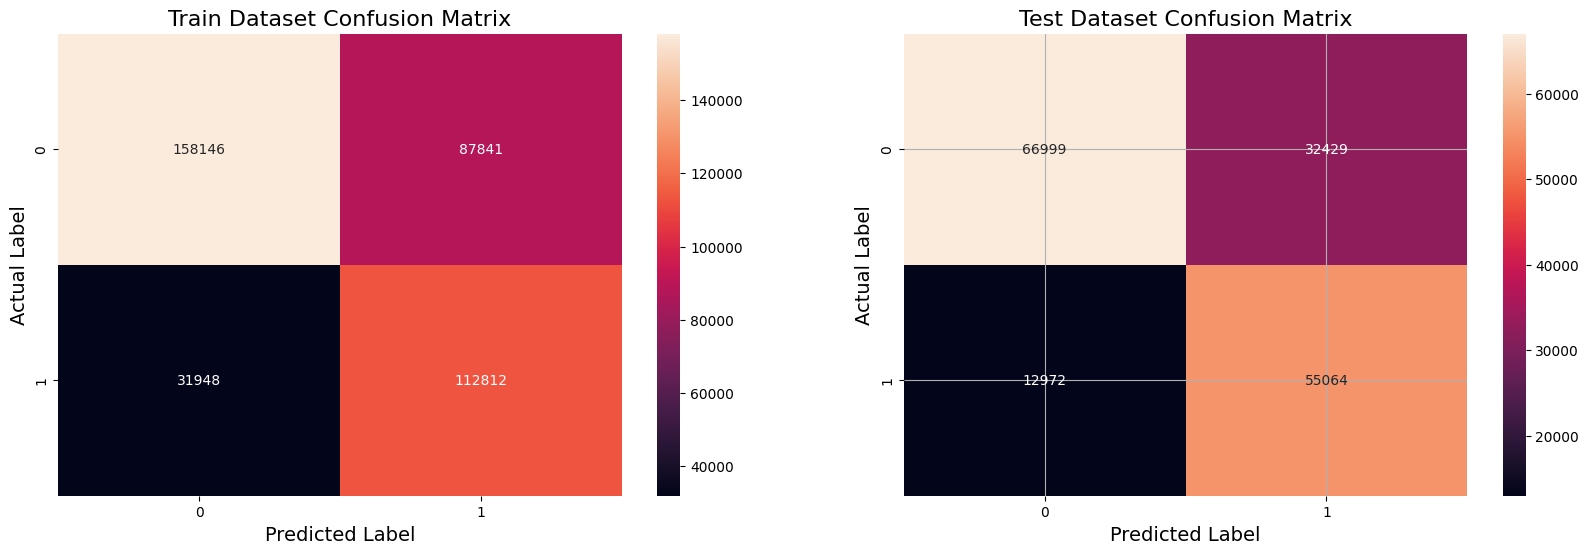

Best Threshold = 0.3290
Model AUC is : 0.7992
Model F1 Score is : 0.7081
Model Recall Score is : 0.8093
Model Accuracy Score is : 0.7289


In [41]:
# Validate LogisticRegression model
import matplotlib.pyplot as plt
test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score = validate_model(log_reg, x_std_train, x_std_val, y_train, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))
print("Model Recall Score is : {:.4f}".format(test_recall_score))
print("Model Accuracy Score is : {:.4f}".format(test_accuracy_score))

In [19]:
# testing with xval
random_forest_model = RandomForestClassifier(min_samples_split=5, n_estimators=200)
random_forest_model.fit(x_std_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200)

Train AUC =  0.9999884187538186
Test AUC =  0.7983939714921245


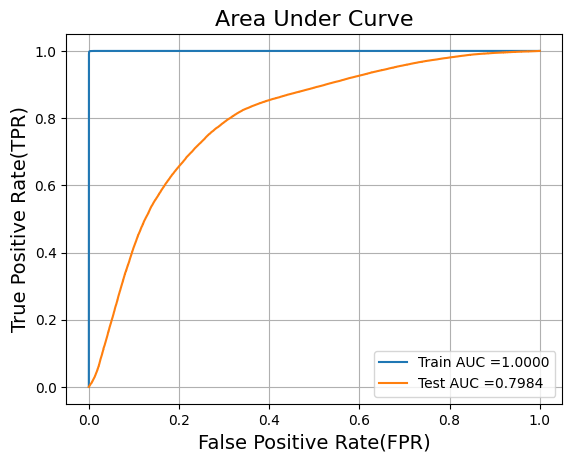

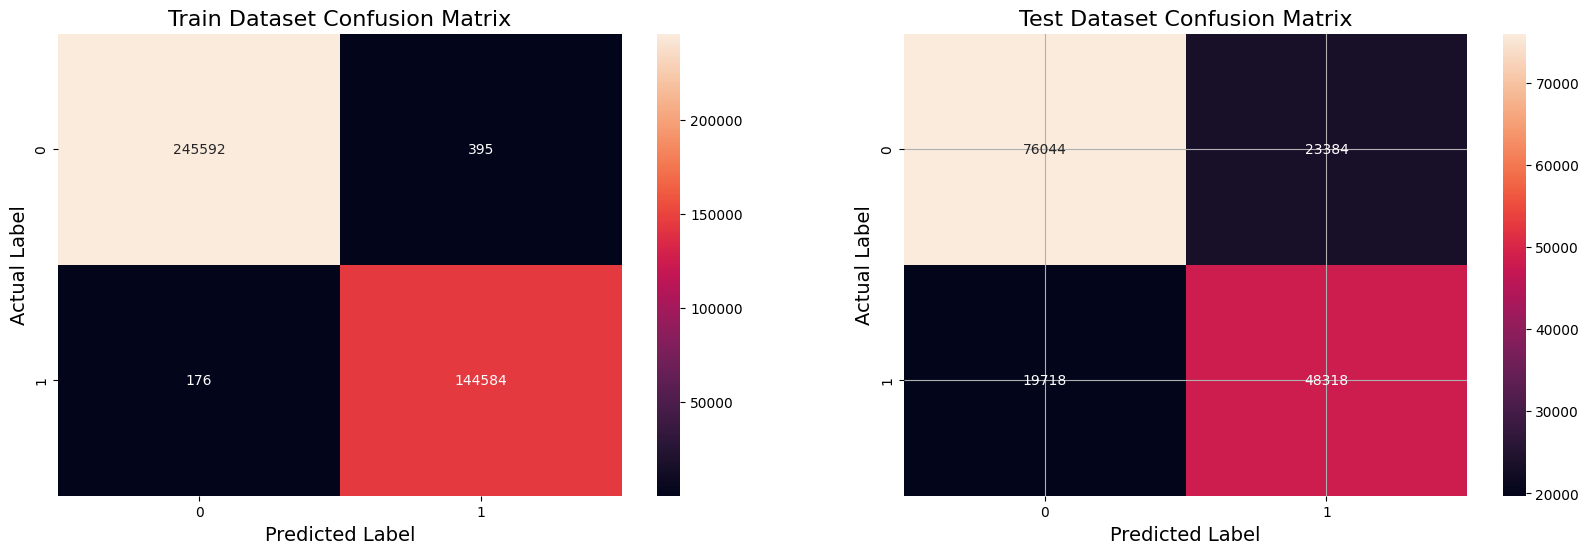

Best Threshold = 0.4353
Model AUC is : 0.7984
Model F1 Score is : 0.6916
Model Recall Score is : 0.7102
Model Accuracy Score is : 0.7426


In [20]:
# Validate LogisticRegression model
import matplotlib.pyplot as plt
test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score = validate_model(random_forest_model, x_std_train, x_std_val, y_train, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))
print("Model Recall Score is : {:.4f}".format(test_recall_score))
print("Model Accuracy Score is : {:.4f}".format(test_accuracy_score))

In [27]:

# # Plot top 20 features
# features = df.columns
# importance_of_feature = random_forest_model.feature_importances_
# imp_feature_indx = np.argsort(random_forest_model.feature_importances_)#[::-1]
# # take_top_20 fratures
# top_20_indices = imp_feature_indx[-20:]
# plt.figure(figsize=(8,7))
# plt.title('Feature Importances for top 20 fratures')
# plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
# plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
# plt.xlabel('Relative Importance')
# plt.show()

#### Use GridSearchCV for DecisionTreeClassifier

In [31]:
# decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

# parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

# decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# decisiontree_cv.fit(x_std_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [32]:
# print("best parameters = ",decisiontree_cv.best_params_)
# print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 5}
roc_auc_score : 0.21564289505783218


#### Train DecisionTreeClassifier with best hyperparameters

In [32]:
# decision_tree = DecisionTreeClassifier(max_depth = 10)
# decision_tree.fit(x_std_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [35]:
decision_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth=10, min_samples_split= 5)
decision_tree.fit(x_std_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)

Train AUC =  0.9183006507864069
Test AUC =  0.730918057843277


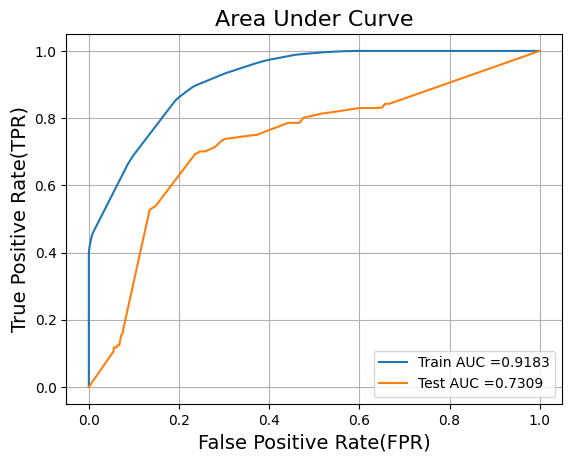

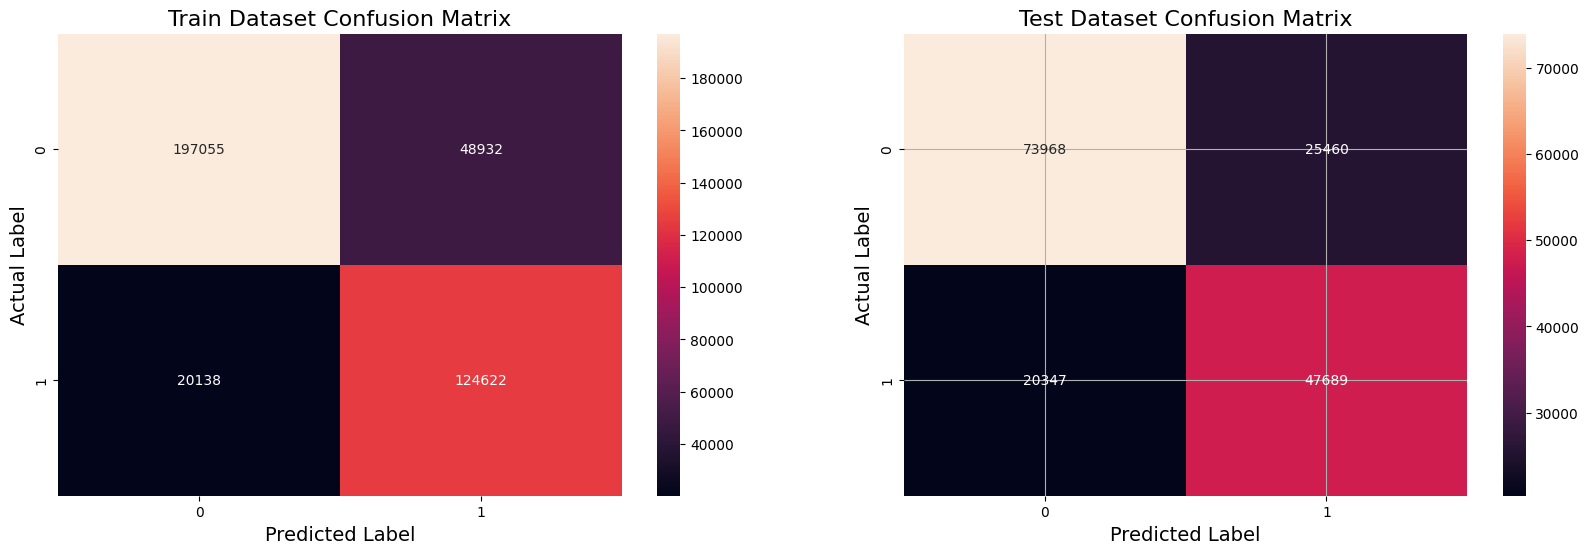

Best Threshold = 0.4100
Model AUC is : 0.7309
Model F1 Score is : 0.6756
Model Recall Score is : 0.7009
Accuracy Score is : 0.7265


In [36]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score = validate_model(decision_tree, x_std_train, x_std_val, y_train, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))
print("Model Recall Score is : {:.4f}".format(test_recall_score))
print("Accuracy Score is : {:.4f}".format(test_accuracy_score))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=0.5)  # Change the kernel and C as needed

# Fit the SVM model on the scaled training data
model.fit(x_std_train, y_train)


#### Use RandomSearchCV for SupportVectorClassifier

In [10]:
# grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
# svm_clf = svm.LinearSVC()
# svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# svm_cv.fit(x_std_train, y_train)

In [36]:
# print("best parameters = ",svm_cv.best_params_)
# print("roc_auc_score :",svm_cv.best_score_)

In [13]:
from sklearn.svm import LinearSVC

# linear_svc = LinearSVC(C=0.5, penalty='l2', max_iter=10000, dual=False)

# # Fit the model
# linear_svc.fit(x_std_train, y_train)

In [14]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_std_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(estimator=LinearSVC(C=0.5))

Train AUC =  0.7619610753068268
Test AUC =  0.7996896208923072


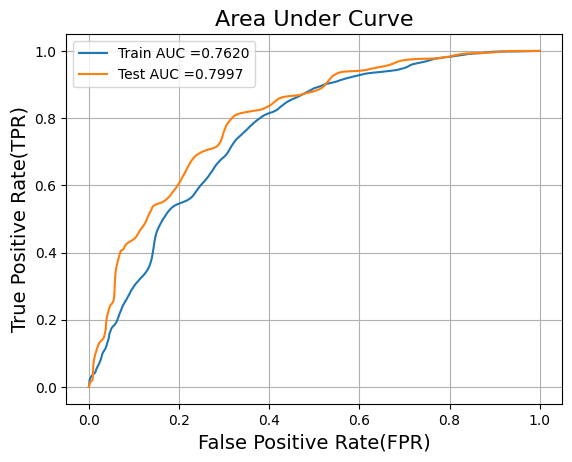

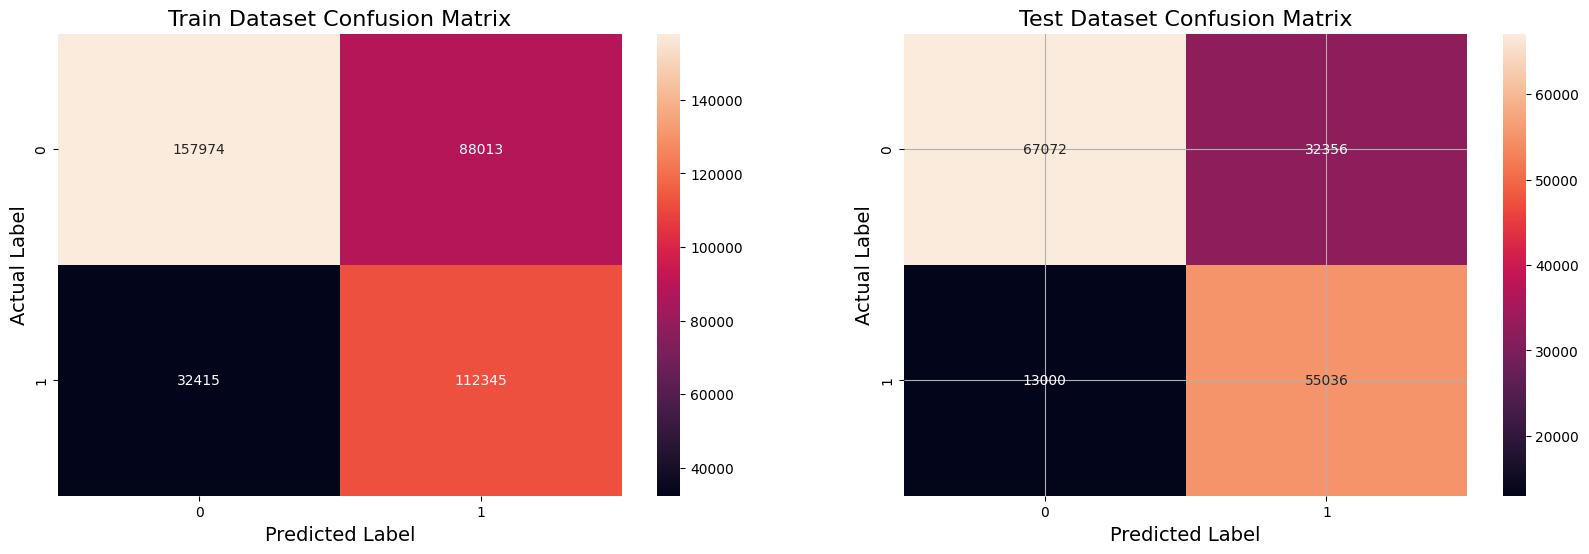

Best Threshold = 0.4145
Model AUC is : 0.7997
Model F1 Score is : 0.7082
Model Recall Score is : 0.8089
Model Accuracy Score is : 0.7292


In [16]:
# Validate SVC model
import matplotlib.pyplot as plt
test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score = validate_model(clb_clf_svc, x_std_train, x_std_val, y_train, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))
print("Model Recall Score is : {:.4f}".format(test_recall_score))
print("Model Accuracy Score is : {:.4f}".format(test_accuracy_score))

#### Train GaussianNB Classifier

In [17]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_std_train, y_train)

GaussianNB()

Train AUC =  0.6940492630759518
Test AUC =  0.5


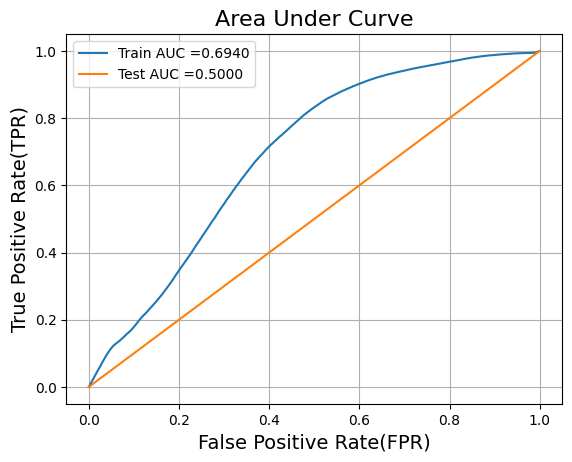

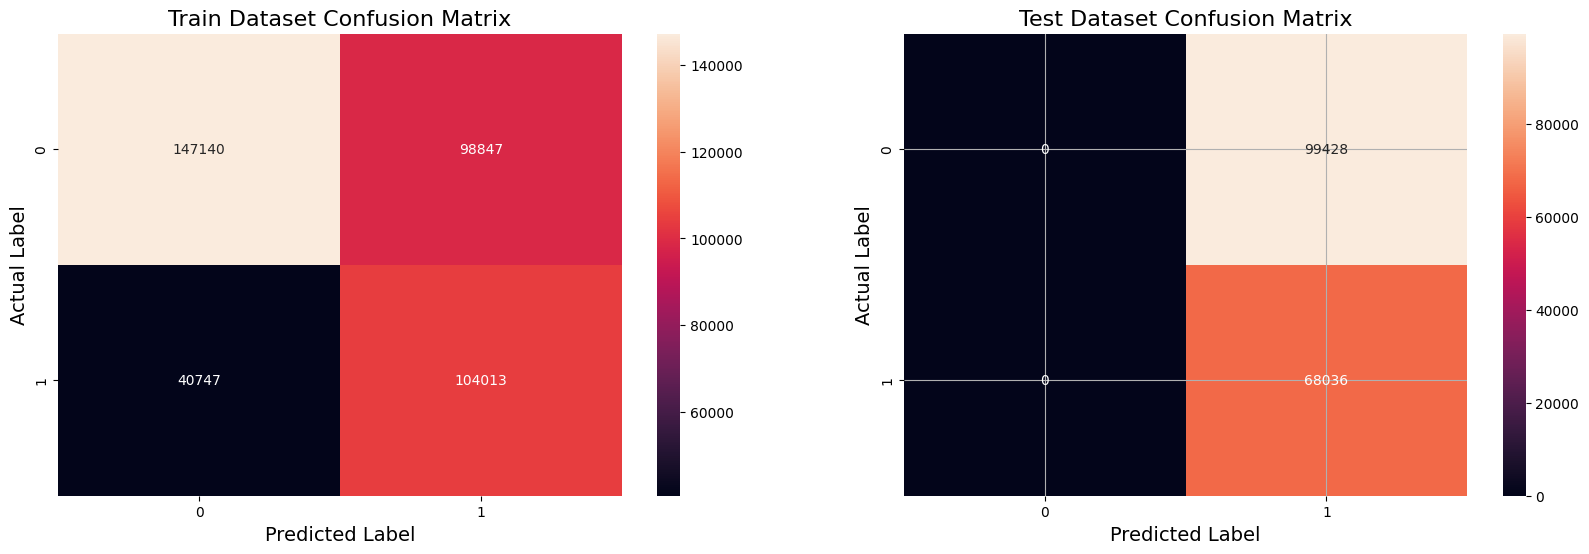

Best Threshold = 0.0000
Model AUC is : 0.5000
Model F1 Score is : 0.5778
Model Recall Score is : 1.0000
Model Accuracy Score is : 0.4063


In [18]:
# Validate NB model
import matplotlib.pyplot as plt
test_auc, test_f1_score, best_t,test_recall_score,test_accuracy_score = validate_model(gaussian_nb, x_std_train, x_std_val, y_train, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))
print("Model Recall Score is : {:.4f}".format(test_recall_score))
print("Model Accuracy Score is : {:.4f}".format(test_accuracy_score))